# Load Data Set

In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

mpl.rcParams['axes.unicode_minus'] = False

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("../input/bike-sharing-demand/train.csv", parse_dates=['datetime'])
train.shape

train.head()

In [ ]:
test= pd.read_csv("../input/bike-sharing-demand/test.csv", parse_dates=['datetime'])
test.shape
test.head()


# Feature Engineering

train['datetime']에 있는 2011-01-20 시간 : 분 : 초 단위를  
연도, 월, 일, 시간, 분, 초, 주차로 모두 세분화하여 새 columns를 추가한다.  
  
따라서 초기 train.shape : (10886,12) -> (10,886,19)로 7개의 columns가 추가된다.  


In [ ]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape
train.head()

위 train과 마찬가지로  
test['datetime']에 있는 2011-01-20 시간 : 분 : 초 단위를  
연도, 월, 일, 시간, 분, 초, 주차로 모두 세분화하여 새 columns를 추가한다.  
  
따라서 초기 test.shape : (6493,9) -> (6493, 16)로 7개의 columns가 추가된다.  

In [ ]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape
test.head()

In [ ]:
fig, axes = plt.subplots(nrows = 2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha = 'right')
axes[0].set(ylabel = 'Count', title ='train windspeed')
sns.countplot(data= train, x='windspeed',ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha ='right')
axes[1].set(ylabel = 'Count', title ='test windspeed')
sns.countplot(data= test, x='windspeed',ax = axes[1])

- widespeed : 풍속이 0에 가장 많다. 
- 측정이 되지 않은 데이터를 0으로 기록한 것으로 보인다.
- 잘못 기록된 데이터를 고쳐줘야한다.   
    
    
- 따라서 풍속의 0값에 특정 값을 넣어준다.
- 평균을 구해서 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 되지는 않을것 같다.
#### M/L을 이용해 예측하고 풍속을 넣어보자!
- 풍속이 0(dataWind0)인 것이 test data set이 된다. 
- 풍속이 0이 아닌것(dataWind_Not0)이 train data set이 된다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [ ]:
train = predict_windspeed(train)

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right') 
ax1.set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data = train, x = 'windspeed', ax = ax1)

---

# Feature Selection
- 신호와 잡음을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.


---
- 연속형 feature와 범주형 feature  
- 연속형 feature = ["temp" , "humidity", 'windspeed' , "atemp" ]  
- 범주형 feature의 type을 카테고리로 변경해준다.  
  왜냐하면 season을 예로들면, [1,2,3,4]가 각 계절을 의미한다.  
  여름(2)와 겨울(4)사이에 두배 차이난다는 특성이 있는게 아니기 때문에 범주형으로 바꿔준다.


In [ ]:
categorical_feature_names = [ 'season', 'holiday', 'workingday',
                             'weather' ,'dayofweek','month','year','hour']
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [ ]:
feature_names = ['season', 'weather','temp','atemp','humidity','windspeed',
                 'year','hour','dayofweek','holiday','workingday']
feature_names

In [ ]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

In [ ]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

#### 연속형 피쳐와 범주형 피쳐로 나누고,  X_train, X_test를 새로운 행렬을 만들었습니다.
- DataSet 완성
----- 


- 레이블이 될 데이터는 train 데이터에 있는 count 값입니다.  
  -> 이 값을 바탕으로 test의 count를 예측할 것입니다.


In [ ]:
label_name = 'count'
y_train = train[label_name]

print(y_train.shape)
y_train.head()

# Scroe
### RMSLE
과대평가 된 항목보다는 과소평가 된 항목에 패널티를 부여합니다.    
  
오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱(Root)입니다.  
  
따라서 값이 작을 수록 정밀도가 높습니다.     
  
-> 0에 가까운 값이 나올 수록 정밀도가 높은 값입니다.    
  
Sunbmissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)  


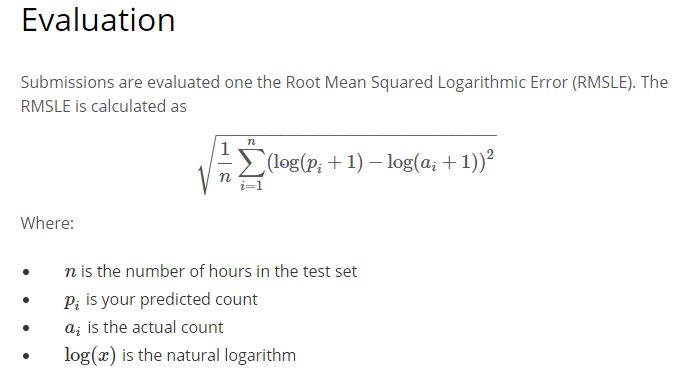



1) numpy로 배열 형태 바꾸기  
2) 예측값과 실제 값에 1을 더하고 로그를 씌우기  
3) 위에서 계산한 예측값에서 실제값을 빼주고 제곱  
4) 평균을 낸다.  
5) 다시 루트를 씌운다.  

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values +1)
    log_actual = np.log(actual_values +1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

### Cross Validation 교차검증

- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습하는 방법입니다.

- K-Fold 교차검증
    - 데이터를 폴드라 부르는 비슷한 크기의 부분집합으로 나눕니다.
    - 부분으로 나눈 각각의 폴드의 정확도를 측정합니다.
    - 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습합니다.
    - 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가합니다.
    - 두 번째 폴드가 테스트 세트가 되고, 나머지 폴들의 훈련 세트를 두 번째 폴드로 정확도를 측정합니다.
    - 이 과정을 마지막 폴드까지 반복합니다.
    - 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 K-Fold 교차검증의 정확도가 됩니다.
   
    

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle = True, random_state = 0)


# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor 

max_depth_list = []

model = RandomForestRegressor(n_estimators = 300 , n_jobs = -1, random_state= 42)

model

In [ ]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring = rmsle_scorer)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print('Score = {0:.5f}'.format(score))

## Train 

- 학습시킴, 피팅 -> 피처와 레이블을 넣어주면 알아서 학습이 된다.

In [ ]:
model.fit(X_train, y_train)

In [ ]:
#예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

#### 예측한 데이터를 시각화.


In [ ]:
fir,(ax1, ax2)=plt.subplots(ncols =2 )

fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')


# Submit


In [ ]:
path = '../input/bike-sharing-demand/sampleSubmission.csv'
submission = pd.read_csv(path)

submission

submission['count'] = predictions

print(submission.shape)
submission.head()
